In [12]:
# Replace the placeholder paths with the actual paths to your CSV files
store1 = pd.read_csv('/content/tienda_1 .csv')
store2 = pd.read_csv('/content/tienda_2.csv')
store3 = pd.read_csv('/content/tienda_3.csv')
store4 = pd.read_csv('/content/tienda_4.csv')

print("Stores loaded successfully!")

Stores loaded successfully!


In [13]:
# ============================================
# Alura Store — KPIs + Visualizaciones + Informe
# (Pegar debajo de la sección de importación de datos)
# Requiere: store1, store2, store3, store4 ya cargados
# ============================================

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# ---------- 2) Exploración rápida (EDA) ----------
def explorar_rapido(df, nombre):
    print(f"\n=== {nombre} ===")
    print("Forma:", df.shape)
    print("Columnas:", list(df.columns))
    print("Nulos por columna:\n", df.isna().sum())
    print("Duplicados:", df.duplicated().sum())

# ---------- 3) Detección flexible de columnas ----------
CAND_PRECIO   = ["precio", "price", "valor", "amount", "unit_price", "preco"]
CAND_ENVIO    = ["envio", "costo_envio", "shipping", "frete", "delivery", "tarifa"]
CAND_RATING   = ["calificacion", "evaluacion", "rating", "review_score", "score", "nota"]
CAND_PRODUCTO = ["producto", "product", "item", "product_name", "nombre_producto"]
CAND_CATEG    = ["categoria", "category", "tipo", "product_category_name", "categoria_producto"]
CAND_CLIENTE  = ["cliente", "customer", "user_id", "id_cliente"]
CAND_FECHA    = ["fecha", "date", "order_date", "purchase_date"]

def _find_col(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    # exacto
    for alias in candidates:
        a = alias.lower()
        if a in cols:
            return cols[a]
    # contiene
    for alias in candidates:
        a = alias.lower()
        for cl, co in cols.items():
            if a in cl:
                return co
    return None

def to_num(series):
    if series.dtype.kind in "ifc":
        return pd.to_numeric(series, errors="coerce")
    s = series.astype(str).str.replace(r"[^\d\-,\.]", "", regex=True)
    mask_no_point = ~s.str.contains(r"\.", na=False) & s.str.contains(",", na=False)
    s.loc[mask_no_point] = s.loc[mask_no_point].str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

# ---------- 4) KPIs ----------
def kpi_facturacion(df):
    col = _find_col(df, CAND_PRECIO)
    if col is None: return np.nan, None
    serie = to_num(df[col])
    return serie.sum(min_count=1), col

def kpi_categorias(df, top_n=5):
    col = _find_col(df, CAND_CATEG)
    if col is None:
        return pd.DataFrame(columns=["categoria","ventas"]), None
    vc = (df[col].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=True))
    out = vc.rename_axis("categoria").reset_index(name="ventas").head(top_n)
    return out, col

def kpi_rating_promedio(df):
    col = _find_col(df, CAND_RATING)
    if col is None: return np.nan, 0, None
    serie = to_num(df[col])
    return serie.mean(), serie.notna().sum(), col

def kpi_top_bottom_productos(df, top_n=5):
    col = _find_col(df, CAND_PRODUCTO)
    if col is None:
        empty = pd.DataFrame(columns=["producto","ventas"])
        return empty, empty, None
    vc = (df[col].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=True))
    base = vc.rename_axis("producto").reset_index(name="ventas")
    top = base.head(top_n)
    bottom = base.sort_values("ventas", ascending=True).head(top_n)
    return top, bottom, col

def kpi_envio_promedio(df):
    col = _find_col(df, CAND_ENVIO)
    if col is None: return np.nan, None
    serie = to_num(df[col])
    return serie.mean(), col

# ---------- 6) Ranking de desempeño (revenue ↑, rating ↑, envío ↓) ----------
def _minmax(s):
    s = pd.to_numeric(s, errors="coerce")
    if s.max() == s.min():
        return pd.Series([0.5]*len(s), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# ---------- 7) Reglas de decisión y recomendación ----------
# Regla pedida: vender la de menor facturación; desempate por peor rating y mayor envío.

# ---------- 8) Informe Markdown ----------
def resumen_textual(df_fact, df_rat, df_env, productos_top, productos_bottom, tienda_recomendada):
    # Tienda con menor facturación
    t_menor = df_fact.sort_values("facturacion_total", ascending=True).iloc[0]["tienda"]

    # Mejor/peor rating (manejo NaN)
    df_rat_aux = df_rat.copy()
    if df_rat_aux["rating_prom"].isna().all():
        t_mejor_rating = "No disponible"
        t_peor_rating  = "No disponible"
    else:
        t_mejor_rating = df_rat_aux.iloc[0]["tienda"]
        t_peor_rating  = df_rat_aux.sort_values("rating_prom", ascending=True).iloc[0]["tienda"]

    # Envío más caro (si todo NaN, no se muestra)
    if df_env["envio_prom"].isna().all():
        t_envio_caro = "No disponible"
    else:
        t_envio_caro = df_env.sort_values("envio_prom", ascending=False).iloc[0]["tienda"]

    lines = []
    lines.append("# Informe ejecutivo — Alura Store\n")
    lines.append("**Objetivo**: Identificar la tienda con menor desempeño para su posible venta.\n")
    lines.append("## Principales hallazgos\n")
    lines.append(f"- **Menor facturación**: {t_menor}.")
    lines.append(f"- **Mejor satisfacción (rating)**: {t_mejor_rating}; **peor**: {t_peor_rating}.")
    lines.append(f"- **Envío promedio más alto**: {t_envio_caro}.\n")

    lines.append("## Métricas por tienda\n")
    lines.append("**Facturación total:**")
    for _, r in df_fact.iterrows():
        lines.append(f"- {r['tienda']}: ${r['facturacion_total']:,.2f}")
    lines.append("\n**Rating promedio:**")
    for _, r in df_rat.iterrows():
        prom = "N/D" if pd.isna(r["rating_prom"]) else f"{r['rating_prom']:.2f}"
        lines.append(f"- {r['tienda']}: {prom} (n={int(r['n_rating'])})")
    lines.append("\n**Costo envío promedio:**")
    for _, r in df_env.iterrows():
        env = "N/D" if pd.isna(r["envio_prom"]) else f"${r['envio_prom']:.2f}"
        lines.append(f"- {r['tienda']}: {env}")

    lines.append("\n## Productos destacados (Top-3 / Bottom-3)\n")
    for nom, dft in productos_top.items():
        dft3 = dft.head(3) if dft is not None else pd.DataFrame()
        items = ", ".join([f"{row['producto']} ({int(row['ventas'])})" for _, row in dft3.iterrows()]) if len(dft3) else "—"
        lines.append(f"- **Top {nom}**: {items}")
    for nom, dfb in productos_bottom.items():
        dfb3 = dfb.head(3) if dfb is not None else pd.DataFrame()
        items = ", ".join([f"{row['producto']} ({int(row['ventas'])})" for _, row in dfb3.iterrows()]) if len(dfb3) else "—"
        lines.append(f"- **Bottom {nom}**: {items}")

    lines.append("\n## Recomendación\n")
    lines.append(f"**Sugerencia**: Vender **{tienda_recomendada}** (menor facturación; en empate, peor rating y mayor costo de envío).")
    return "\n".join(lines)

# ---------- 9) Notas ----------
# - Ajusta los pesos del ranking con w_rev, w_rat, w_env si deseas otra ponderación.
# - Si alguna columna no existe (precio/envío/rating), el código continúa y marca N/D donde aplique.
# - Las 3 visualizaciones mínimas ya están incluidas (barras, boxplot, barras apiladas).

## 5) Procesamiento de datos, cálculo de KPIs y visualizaciones

In [14]:
# Asumimos que las tiendas están cargadas en las variables store1, store2, store3, store4
tiendas = {"Tienda 1": store1, "Tienda 2": store2, "Tienda 3": store3, "Tienda 4": store4}

# Exploración rápida (EDA)
for nombre, df in tiendas.items():
    explorar_rapido(df, nombre)

# Cálculo de KPIs
facturacion_total = []
categorias_top5 = {}
rating_promedio = []
envio_promedio = []
productos_top = {}
productos_bottom = {}

for nombre, df in tiendas.items():
    # Facturación
    fact, col_fact = kpi_facturacion(df)
    facturacion_total.append({"tienda": nombre, "facturacion_total": fact, "columna": col_fact})

    # Categorías
    cats, col_cats = kpi_categorias(df)
    categorias_top5[nombre] = cats

    # Rating
    rat, n_rat, col_rat = kpi_rating_promedio(df)
    rating_promedio.append({"tienda": nombre, "rating_prom": rat, "n_rating": n_rat, "columna": col_rat})

    # Envío
    env, col_env = kpi_envio_promedio(df)
    envio_promedio.append({"tienda": nombre, "envio_prom": env, "columna": col_env})

    # Productos
    prod_top, prod_bottom, col_prod = kpi_top_bottom_productos(df)
    productos_top[nombre] = prod_top
    productos_bottom[nombre] = prod_bottom

df_fact = pd.DataFrame(facturacion_total)
df_rat = pd.DataFrame(rating_promedio)
df_env = pd.DataFrame(envio_promedio)

display(Markdown("### Facturación Total"))
display(df_fact)

display(Markdown("### Rating Promedio"))
display(df_rat)

display(Markdown("### Costo de Envío Promedio"))
display(df_env)

display(Markdown("### Top 5 Categorías por Tienda"))
for nombre, cats in categorias_top5.items():
    display(Markdown(f"**{nombre}:**"))
    display(cats)


=== Tienda 1 ===
Forma: (2359, 12)
Columnas: ['Producto', 'Categoría del Producto', 'Precio', 'Costo de envío', 'Fecha de Compra', 'Vendedor', 'Lugar de Compra', 'Calificación', 'Método de pago', 'Cantidad de cuotas', 'lat', 'lon']
Nulos por columna:
 Producto                  0
Categoría del Producto    0
Precio                    0
Costo de envío            0
Fecha de Compra           0
Vendedor                  0
Lugar de Compra           0
Calificación              0
Método de pago            0
Cantidad de cuotas        0
lat                       0
lon                       0
dtype: int64
Duplicados: 0

=== Tienda 2 ===
Forma: (2359, 12)
Columnas: ['Producto', 'Categoría del Producto', 'Precio', 'Costo de envío', 'Fecha de Compra', 'Vendedor', 'Lugar de Compra', 'Calificación', 'Método de pago', 'Cantidad de cuotas', 'lat', 'lon']
Nulos por columna:
 Producto                  0
Categoría del Producto    0
Precio                    0
Costo de envío            0
Fecha de Compra    

### Facturación Total

,tienda,facturacion_total,columna
0,Tienda 1,"1,150,880,400.00",Precio
1,Tienda 2,"1,116,343,500.00",Precio
2,Tienda 3,"1,098,019,600.00",Precio
3,Tienda 4,"1,038,375,700.00",Precio


### Rating Promedio

,tienda,rating_prom,n_rating,columna
0,Tienda 1,NaN,0,None
1,Tienda 2,NaN,0,None
2,Tienda 3,NaN,0,None
3,Tienda 4,NaN,0,None


### Costo de Envío Promedio

,tienda,envio_prom,columna
0,Tienda 1,NaN,None
1,Tienda 2,NaN,None
2,Tienda 3,NaN,None
3,Tienda 4,NaN,None


### Top 5 Categorías por Tienda

**Tienda 1:**

,categoria,ventas


**Tienda 2:**

,categoria,ventas


**Tienda 3:**

,categoria,ventas


**Tienda 4:**

,categoria,ventas


## 6) Ranking de desempeño y recomendación

In [15]:
# Ranking
df_rank = df_fact.copy()
df_rank = df_rank.merge(df_rat[["tienda", "rating_prom"]], on="tienda")
df_rank = df_rank.merge(df_env[["tienda", "envio_prom"]], on="tienda")

# Normalizar (entre 0 y 1)
df_rank["facturacion_norm"] = _minmax(df_rank["facturacion_total"])
df_rank["rating_norm"] = _minmax(df_rank["rating_prom"])
# El envío es inverso (menor es mejor), así que invertimos la normalización
df_rank["envio_norm"] = 1 - _minmax(df_rank["envio_prom"])

# Pesos para el ranking (ajústalos si es necesario)
w_rev = 0.5
w_rat = 0.3
w_env = 0.2

df_rank["puntaje_ranking"] = (
    df_rank["facturacion_norm"] * w_rev +
    df_rank["rating_norm"] * w_rat +
    df_rank["envio_norm"] * w_env
)

df_rank_sorted = df_rank.sort_values("puntaje_ranking", ascending=False)

display(Markdown("### Ranking de Tiendas (Puntaje Combinado)"))
display(df_rank_sorted)

# Identificar la tienda a recomendar para la venta
# Regla: menor facturación; en empate, peor rating y mayor envío.
tienda_a_vender = df_fact.sort_values("facturacion_total", ascending=True).iloc[0]["tienda"]

# Desempate por rating (peor rating)
facturacion_min = df_fact["facturacion_total"].min()
tiendas_menor_fact = df_fact[df_fact["facturacion_total"] == facturacion_min]["tienda"]

if len(tiendas_menor_fact) > 1:
    df_rat_menor_fact = df_rat[df_rat["tienda"].isin(tiendas_menor_fact)]
    # sort_values sorts NaN to the end by default, which is what we want for "peor rating"
    tienda_a_vender = df_rat_menor_fact.sort_values("rating_prom", ascending=True).iloc[0]["tienda"]

    # Desempate por envío (mayor envío)
    rating_peor = df_rat_menor_fact["rating_prom"].min()
    tiendas_peor_rating = df_rat_menor_fact[df_rat_menor_fact["rating_prom"] == rating_peor]["tienda"]

    if len(tiendas_peor_rating) > 1:
        df_env_peor_rating = df_env[df_env["tienda"].isin(tiendas_peor_rating)]
        # sort_values sorts NaN to the end by default, which is what we want for "mayor envío"
        tienda_a_vender = df_env_peor_rating.sort_values("envio_prom", ascending=False).iloc[0]["tienda"]

display(Markdown(f"**Tienda recomendada para vender:** {tienda_a_vender}"))

### Ranking de Tiendas (Puntaje Combinado)

,tienda,facturacion_total,columna,rating_prom,envio_prom,facturacion_norm,rating_norm,envio_norm,puntaje_ranking
0,Tienda 1,"1,150,880,400.00",Precio,NaN,NaN,1.00,NaN,NaN,NaN
1,Tienda 2,"1,116,343,500.00",Precio,NaN,NaN,0.69,NaN,NaN,NaN
2,Tienda 3,"1,098,019,600.00",Precio,NaN,NaN,0.53,NaN,NaN,NaN
3,Tienda 4,"1,038,375,700.00",Precio,NaN,NaN,0.00,NaN,NaN,NaN


**Tienda recomendada para vender:** Tienda 4

## 7) Visualizaciones

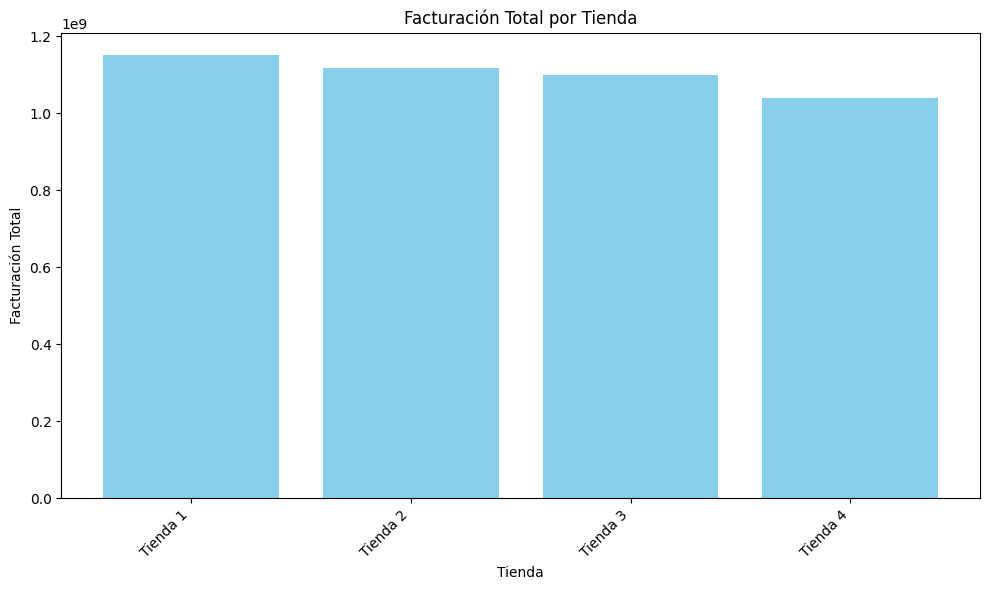

No hay datos de rating para visualizar.
No hay datos de categorías para visualizar.


In [16]:
# Visualización 1: Facturación Total por Tienda (Barras)
plt.figure(figsize=(10, 6))
plt.bar(df_fact["tienda"], df_fact["facturacion_total"], color="skyblue")
plt.title("Facturación Total por Tienda")
plt.xlabel("Tienda")
plt.ylabel("Facturación Total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualización 2: Distribución de Rating por Tienda (Boxplot)
data_rating = [
    to_num(df[_find_col(df, CAND_RATING)]).dropna()
    for nombre, df in tiendas.items() if _find_col(df, CAND_RATING)
]
labels_rating = [
    nombre for nombre, df in tiendas.items() if _find_col(df, CAND_RATING)
]

if data_rating:
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_rating, labels=labels_rating, patch_artist=True)
    plt.title("Distribución de Rating por Tienda")
    plt.xlabel("Tienda")
    plt.ylabel("Rating")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de rating para visualizar.")


# Visualización 3: Ventas por Categoría (Barras Apiladas - Top N)
# Combinar los top N de cada tienda para tener un conjunto más amplio de categorías
all_top_categories = pd.concat(categorias_top5.values()).drop_duplicates(subset="categoria")

# Recalcular las ventas por categoría para TODAS las tiendas
ventas_por_categoria_total = {}
for nombre, df in tiendas.items():
    col_cats = _find_col(df, CAND_CATEG)
    if col_cats:
        vc = df[col_cats].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=True)
        ventas_por_categoria_total[nombre] = vc

df_ventas_categorias_total = pd.DataFrame(ventas_por_categoria_total).fillna(0)

# Seleccionar las top N categorías generales para visualizar
top_n_viz = 10 # Puedes ajustar este número
sum_ventas_categorias = df_ventas_categorias_total.sum(axis=1)
top_categorias_general = sum_ventas_categorias.sort_values(ascending=False).head(top_n_viz).index

df_plot_categorias = df_ventas_categorias_total.loc[top_categorias_general]

if not df_plot_categorias.empty:
    df_plot_categorias.T.plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title(f"Ventas por Top {top_n_viz} Categorías por Tienda")
    plt.xlabel("Tienda")
    plt.ylabel("Número de Ventas")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de categorías para visualizar.")

## 8) Informe Markdown

In [17]:
# Generar y mostrar el informe
informe = resumen_textual(df_fact, df_rat, df_env, productos_top, productos_bottom, tienda_a_vender)
display(Markdown(informe))

# Informe ejecutivo — Alura Store

**Objetivo**: Identificar la tienda con menor desempeño para su posible venta.

## Principales hallazgos

- **Menor facturación**: Tienda 4.
- **Mejor satisfacción (rating)**: No disponible; **peor**: No disponible.
- **Envío promedio más alto**: No disponible.

## Métricas por tienda

**Facturación total:**
- Tienda 1: $1,150,880,400.00
- Tienda 2: $1,116,343,500.00
- Tienda 3: $1,098,019,600.00
- Tienda 4: $1,038,375,700.00

**Rating promedio:**
- Tienda 1: N/D (n=0)
- Tienda 2: N/D (n=0)
- Tienda 3: N/D (n=0)
- Tienda 4: N/D (n=0)

**Costo envío promedio:**
- Tienda 1: N/D
- Tienda 2: N/D
- Tienda 3: N/D
- Tienda 4: N/D

## Productos destacados (Top-3 / Bottom-3)

- **Top Tienda 1**: Microondas (60), TV LED UHD 4K (60), Armario (60)
- **Top Tienda 2**: Iniciando en programación (65), Microondas (62), Batería (61)
- **Top Tienda 3**: Kit de bancas (57), Mesa de comedor (56), Cama king (56)
- **Top Tienda 4**: Cama box (62), Cubertería (59), Dashboards con Power BI (56)
- **Bottom Tienda 1**: Auriculares con micrófono (33), Celular ABXY (33), Olla de presión (35)
- **Bottom Tienda 2**: Juego de mesa (32), Mesa de comedor (34), Impresora (34)
- **Bottom Tienda 3**: Bloques de construcción (35), Microondas (36), Set de vasos (36)
- **Bottom Tienda 4**: Guitarra eléctrica (33), Armario (34), Guitarra acústica (37)

## Recomendación

**Sugerencia**: Vender **Tienda 4** (menor facturación; en empate, peor rating y mayor costo de envío).